In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
# standard_cut_keys = ['LLHLF_reco_exists', 'LLHLF_zenith', 'num_hits_1_30', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_30', 'LLHLF_containment', 'energy_range']
# standard_cut_keys = ['LLHlap_reco_exists', 'LLHlap_zenith', 'num_hits_1_30', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_30', 'LLHlap_containment', 'energy_range']
# standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits_1_60', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_60', 'reco_containment', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:104: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 62761


Get error in charge vs. energy distribution

In [5]:
pipeline = comp.get_pipeline('KN')
param_range = np.arange(3, 200, 25)
param_grid = {'classifier__n_neighbors': param_range}
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  verbose=1,
                  n_jobs=10)
gs = gs.fit(X_train, y_train)
print('best GS CV score = {}'.format(gs.best_score_))
print('best GS CV depths = {}'.format(gs.best_params_))
print('Grid scores on development set:')
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
pipeline.set_params(**gs.best_params_)
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best GS CV score = 0.546342473829
best GS CV depths = {'classifier__n_neighbors': 128}
Grid scores on development set:
0.480 (+/-0.011) for {'classifier__n_neighbors': 3}
0.540 (+/-0.005) for {'classifier__n_neighbors': 28}
0.544 (+/-0.007) for {'classifier__n_neighbors': 53}
0.545 (+/-0.008) for {'classifier__n_neighbors': 78}
0.545 (+/-0.007) for {'classifier__n_neighbors': 103}
0.546 (+/-0.005) for {'classifier__n_neighbors': 128}
0.545 (+/-0.006) for {'classifier__n_neighbors': 153}
0.545 (+/-0.006) for {'classifier__n_neighbors': 178}


[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:   25.8s finished


In [6]:
clf_name = clf.__class__.__name__
print('=' * 30)
print(clf_name)
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))
scores = cross_val_score(
    estimator=pipeline, X=X_test, y=y_test, cv=10, n_jobs=10)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

KNeighborsClassifier
Test accuracy: 54.6026%
Train accuracy: 55.6635%
CV score: 53.80% (+/- 0.60%)


In [7]:
comp_list = ['P', 'He', 'Fe']
# comp_list = ['P', 'Fe']
# comp_list = le.inverse_transform(np.unique(y_test))

correctly_identified_mask = (test_predictions == y_test)

# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
# energy_bins = np.arange(6.2, 9.51, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
log_energy = X_test[:, 0]

# Construct MC composition masks
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = (le.inverse_transform(y_test) == composition)

# Get number of MC comp in each reco energy bin
num_MC_energy, num_MC_energy_err = {}, {}
for composition in comp_list:
    num_MC_energy[composition] = np.histogram(log_energy[MC_comp_mask[composition]],
                                     bins=energy_bins)[0]
    num_MC_energy_err[composition] = np.sqrt(num_MC_energy[composition])

num_MC_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
num_MC_energy_err['total'] = np.sqrt(num_MC_energy['total'])


# Get number of correctly identified comp in each reco energy bin
num_reco_energy, num_reco_energy_err = {}, {}
for composition in comp_list:
    num_reco_energy[composition] = np.histogram(
        log_energy[MC_comp_mask[composition] & correctly_identified_mask],
        bins=energy_bins)[0]
    num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

num_reco_energy['total'] = np.histogram(log_energy[correctly_identified_mask],
                                        bins=energy_bins)[0]
num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])



# Calculate correctly identified fractions as a function of MC energy
reco_frac, reco_frac_err = {}, {}
for composition in comp_list:
    print(composition)
    reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
        num_reco_energy[composition], num_reco_energy_err[composition],
        num_MC_energy[composition], num_MC_energy_err[composition])
    
reco_frac['total'], reco_frac_err['total'] = comp.ratio_error(
        num_reco_energy['total'], num_reco_energy_err['total'],
        num_MC_energy['total'], num_MC_energy_err['total'])

P
He
Fe


textstr = 
Training features: 
1) $\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$
2) InIce charge (top 50\%)
3) $\cos(\theta_{\mathrm{Lap}})$
4) NChannels (top 50\%)
5) $\log_{10}(S_{\mathrm{125}})$


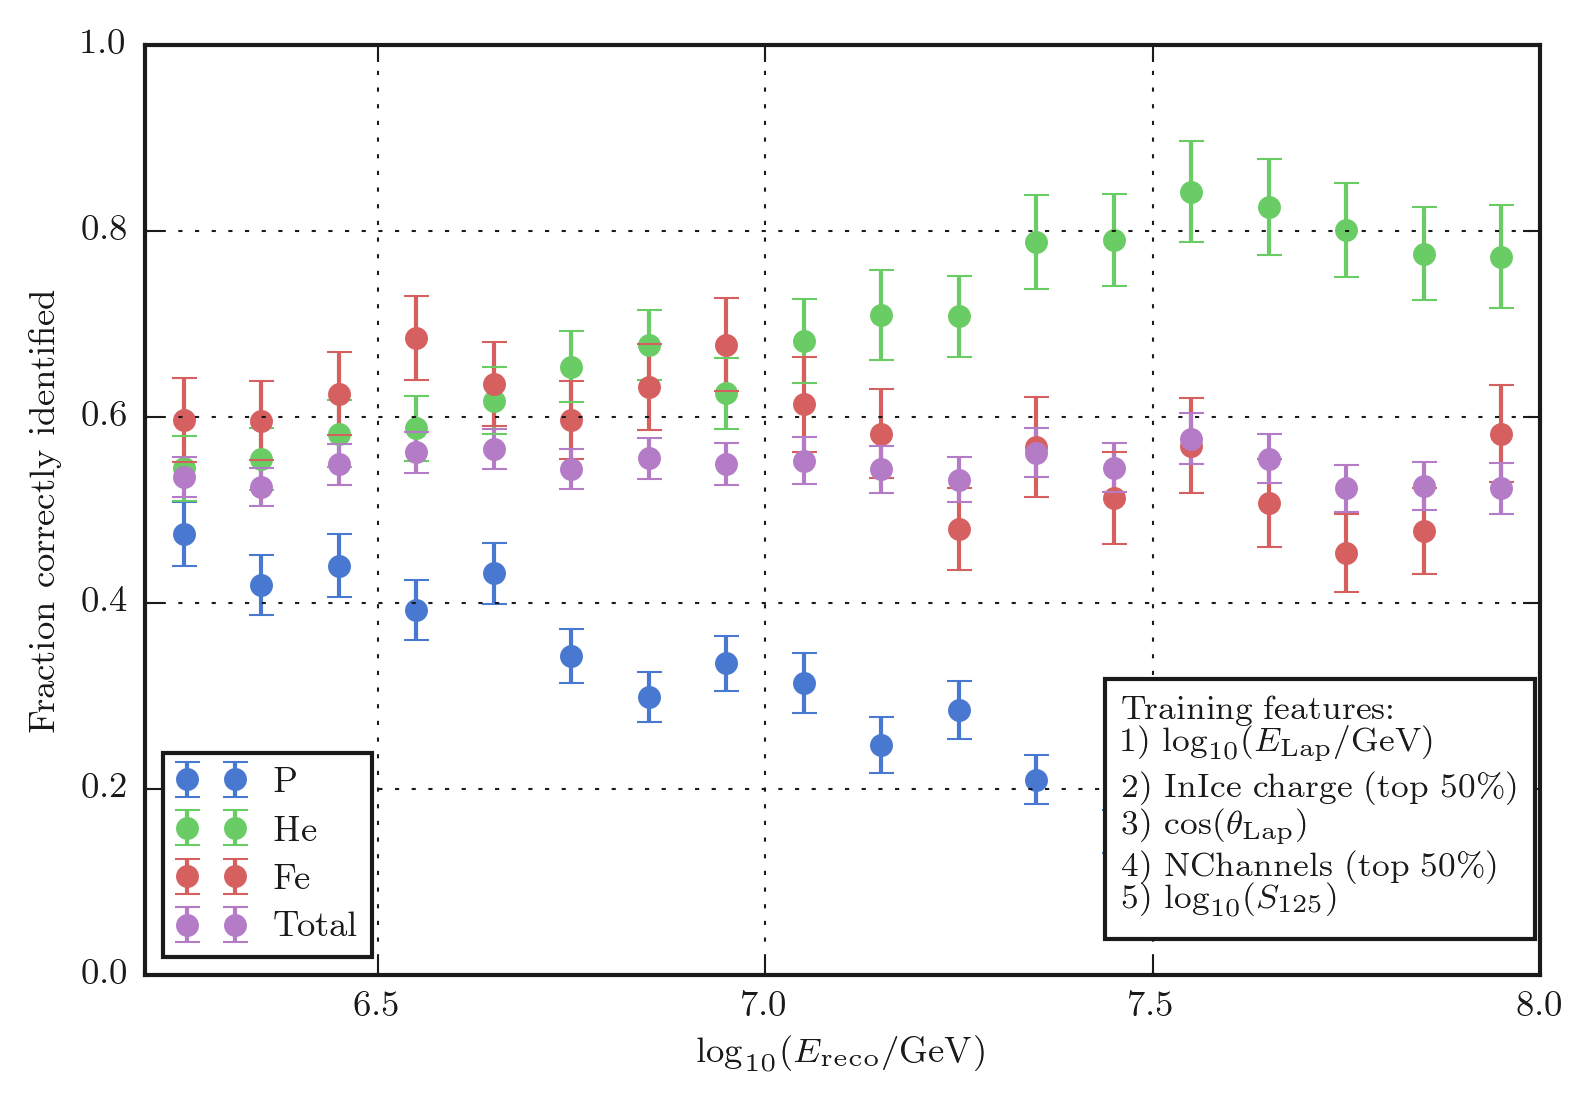

In [8]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for composition in comp_list:
    ax.errorbar(energy_midpoints, reco_frac[composition],
                yerr=reco_frac_err[composition],
                # xerr=energy_bin_width / 2,
                marker='.', markersize=10,
                label=composition)
ax.errorbar(energy_midpoints, reco_frac['total'],
                yerr=reco_frac_err['total'],
                # xerr=energy_bin_width / 2,
                marker='.', markersize=10,
                label='Total')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
plt.grid()
plt.legend(loc=3)
# place a text box in upper left in axes coords
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
print('textstr = \n' + textstr)
props = dict(facecolor='white')
ax.text(0.7, 0.3, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
outfile = '/home/jbourbeau/public_html/figures/composition' + \
          '/fraction-reco-correct_vs_reco-energy_RF.png'
plt.savefig(outfile)
plt.show()

In [11]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
plt.ylim([0, .40])
plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

(array([  2.00000000e+00,   3.10000000e+01,   5.24000000e+02,
          7.77000000e+02,   2.02700000e+03,   2.64900000e+03,
          7.03000000e+02,   1.18000000e+02,   3.50000000e+01,
          7.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

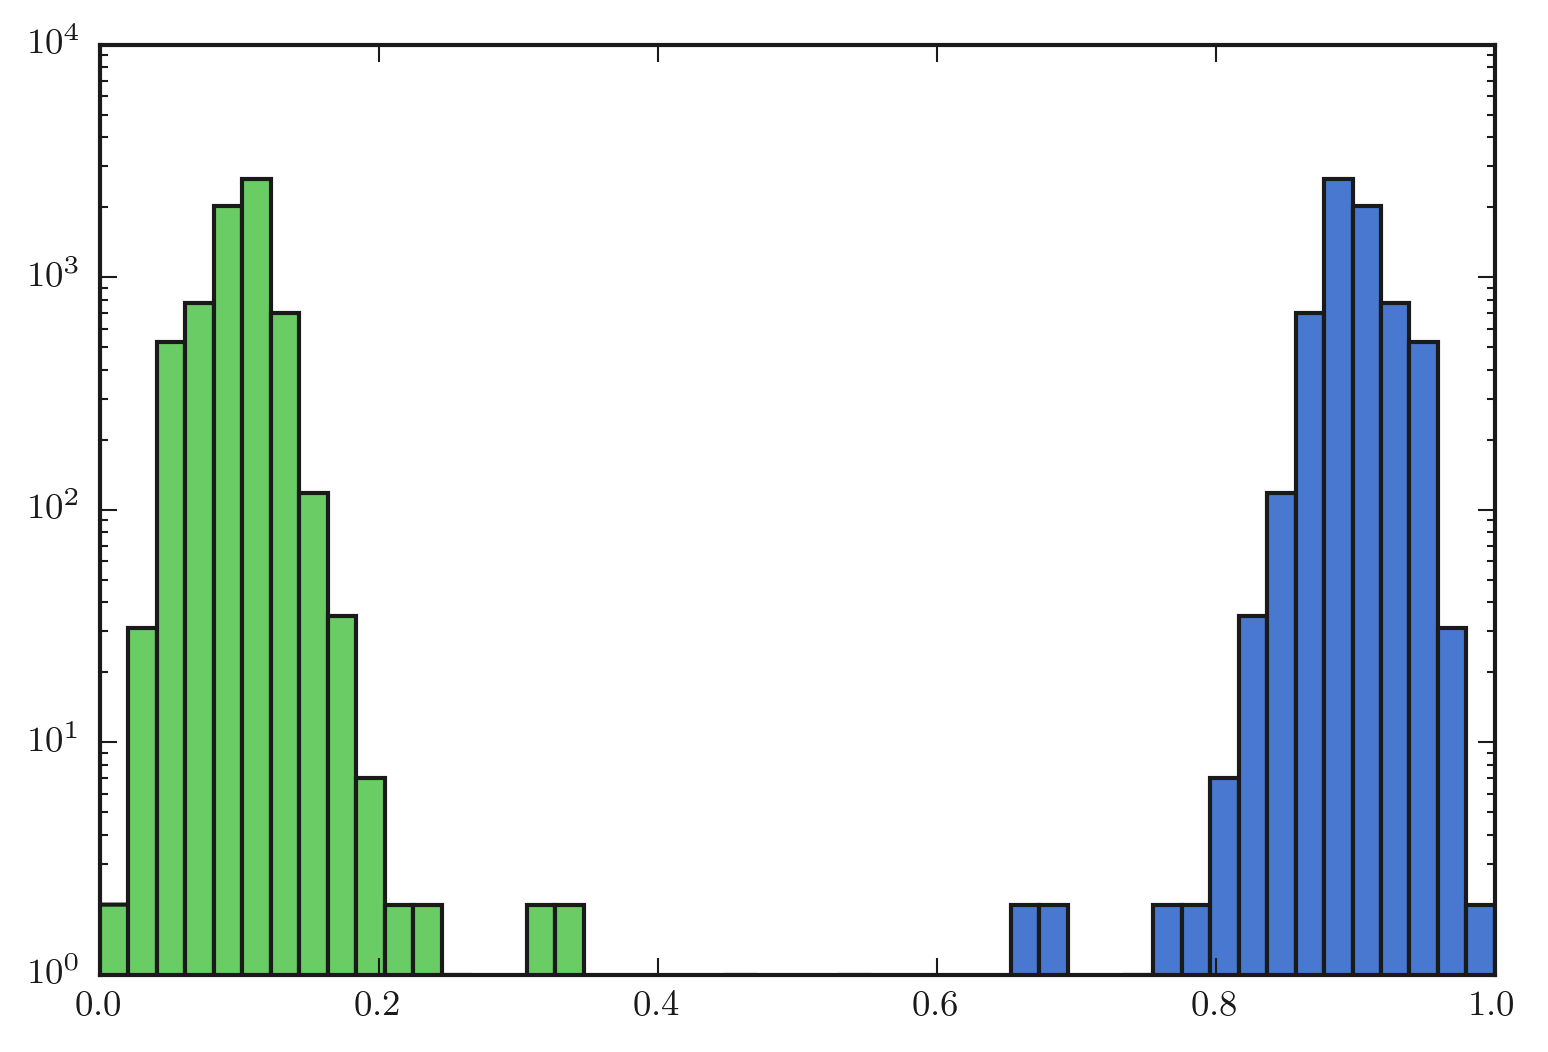

In [10]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

-0.181446352644
0.976533857996
-0.101248002643
0.975933857996


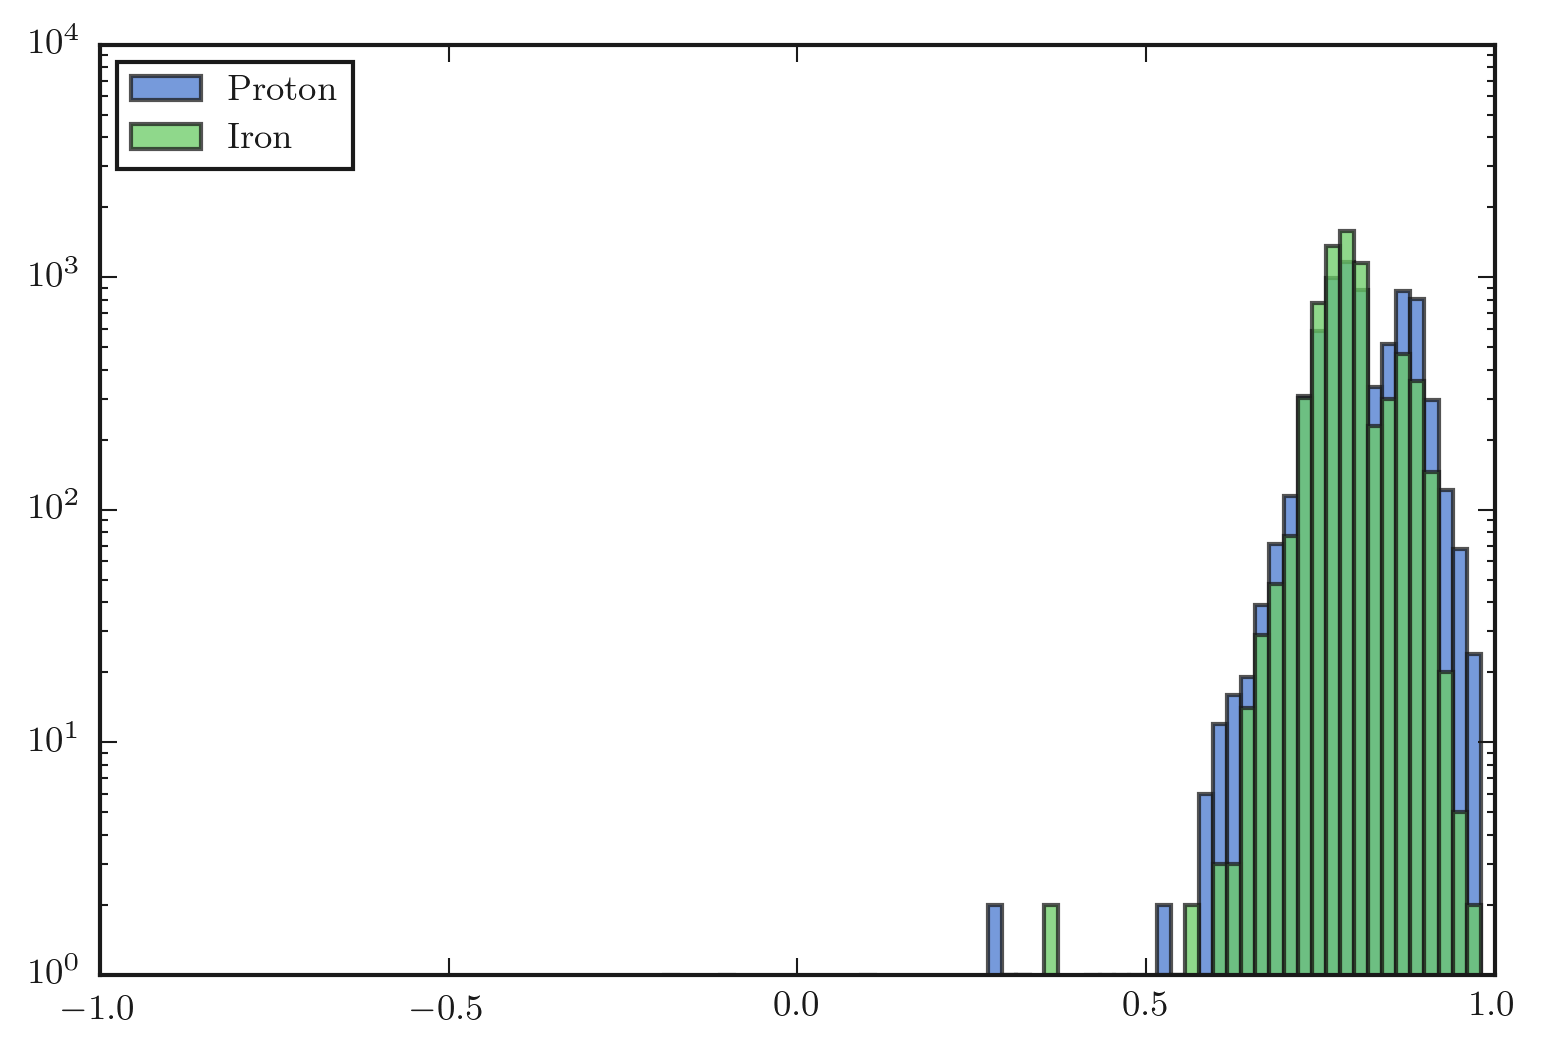

array([0, 1])

In [11]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [12]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

[0 1]


array(['Fe', 'P'], dtype=object)

In [13]:
pipeline.named_steps['classifier'].decision_path(X_test)

(<14147x694890 sparse matrix of type '<type 'numpy.int64'>'
 	with 19243683 stored elements in Compressed Sparse Row format>,
 array([     0,   7047,  13470,  20773,  27974,  35149,  41448,  48387,
         55696,  62693,  69796,  76533,  83826,  90853,  98064, 105223,
        111478, 118187, 125196, 131995, 138500, 145857, 152970, 159613,
        166858, 174085, 181236, 187877, 195112, 201497, 208524, 215683,
        222988, 230345, 237718, 244321, 251140, 257961, 265336, 272169,
        278984, 285313, 292358, 299691, 306962, 314047, 321310, 328261,
        335644, 342869, 350128, 357317, 364462, 371425, 378714, 385583,
        392688, 399891, 406886, 413735, 420680, 427243, 434242, 441499,
        448432, 455393, 462526, 469699, 476204, 483049, 489802, 496651,
        503748, 510789, 516850, 523781, 531098, 538215, 545404, 552077,
        558406, 564769, 571830, 578987, 586058, 592511, 599776, 607011,
        614402, 620707, 627910, 634999, 642028, 646705, 653084, 659563,
        66